# Advanced Modeling: Deep Learning for Network Traffic Classification

This notebook implements and evaluates advanced deep learning models (MLP, Autoencoder) for binary classification (normal vs. attack) using the UNSW-NB15 dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

2025-05-21 15:37:49.613358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 15:37:49.623564: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 15:37:49.647414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747822069.685920   15602 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747822069.696821   15602 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747822069.729613   15602 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Load processed data
df = pd.read_csv('../data/processed/unsw-nb15.csv')
print('Shape:', df.shape)
df.head()

Shape: (257673, 44)


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [8]:
# Identify categorical and numeric columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col not in ['attack_cat']]  # Exclude multiclass label for now
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col not in ['label']]  # Exclude label

# One-hot encode categoricals
# One-hot encode categoricals
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(df[cat_cols]) if cat_cols else np.empty((len(df), 0))

# Standard scale numerics
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

# Combine features
import numpy as np
X = np.hstack([X_num, X_cat]) if X_cat.size else X_num

# Prepare y for binary classification
y = df['label']
if y.dtype != int and y.dtype != float:
    y = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (206138, 196) Test shape: (51535, 196)


In [9]:
from tensorflow.keras import layers, models, callbacks

# Define the model architecture
def build_mlp(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

mlp = build_mlp(X_train.shape[1])
mlp.summary()

E0000 00:00:1747823324.533991   15602 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747823324.542457   15602 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        25,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,481 (142.50 KB)

 Trainable params: 36,033 (140.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_mlp_model.h5', save_best_only=True, monitor='val_loss')

history = mlp.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[early_stop, checkpoint],
    verbose=2
)

Epoch 1/50


2025-05-21 16:01:04.050602: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129289440 exceeds 10% of free system memory.


645/645 - 7s - 11ms/step - accuracy: 0.8865 - auc: 0.9618 - loss: 0.2255 - val_accuracy: 0.9069 - val_auc: 0.9800 - val_loss: 0.1627
Epoch 2/50


645/645 - 3s - 4ms/step - accuracy: 0.9065 - auc: 0.9766 - loss: 0.1742 - val_accuracy: 0.9189 - val_auc: 0.9827 - val_loss: 0.1522
Epoch 3/50


645/645 - 3s - 5ms/step - accuracy: 0.9121 - auc: 0.9794 - loss: 0.1646 - val_accuracy: 0.9238 - val_auc: 0.9841 - val_loss: 0.1454
Epoch 4/50


645/645 - 5s - 8ms/step - accuracy: 0.9164 - auc: 0.9811 - loss: 0.1583 - val_accuracy: 0.9268 - val_auc: 0.9849 - val_loss: 0.1424
Epoch 5/50


645/645 - 3s - 5ms/step - accuracy: 0.9183 - auc: 0.9818 - loss: 0.1555 - val_accuracy: 0.9252 - val_auc: 0.9850 - val_loss: 0.1417
Epoch 6/50


645/645 - 3s - 4ms/step - accuracy: 0.9199 - auc: 0.9825 - loss: 0.1524 - val_accuracy: 0.9272 - val_auc: 0.9856 - val_loss: 0.1387
Epoch 7/50
645/645 - 3s - 4ms/step - accuracy: 0.9201 - auc: 0.9827 - loss: 0.1513 - val_accuracy: 0.9271 - val_auc: 0.9860 - val_loss: 0.1406
Epoch 8/50


645/645 - 4s - 6ms/step - accuracy: 0.9225 - auc: 0.9834 - loss: 0.1483 - val_accuracy: 0.9292 - val_auc: 0.9859 - val_loss: 0.1380
Epoch 9/50


645/645 - 3s - 5ms/step - accuracy: 0.9235 - auc: 0.9837 - loss: 0.1470 - val_accuracy: 0.9307 - val_auc: 0.9866 - val_loss: 0.1371
Epoch 10/50
645/645 - 5s - 7ms/step - accuracy: 0.9250 - auc: 0.9841 - loss: 0.1458 - val_accuracy: 0.9248 - val_auc: 0.9857 - val_loss: 0.1411
Epoch 11/50


645/645 - 3s - 5ms/step - accuracy: 0.9256 - auc: 0.9842 - loss: 0.1450 - val_accuracy: 0.9307 - val_auc: 0.9864 - val_loss: 0.1360
Epoch 12/50


645/645 - 4s - 7ms/step - accuracy: 0.9272 - auc: 0.9846 - loss: 0.1435 - val_accuracy: 0.9333 - val_auc: 0.9869 - val_loss: 0.1336
Epoch 13/50
645/645 - 4s - 6ms/step - accuracy: 0.9272 - auc: 0.9847 - loss: 0.1432 - val_accuracy: 0.9323 - val_auc: 0.9870 - val_loss: 0.1341
Epoch 14/50


645/645 - 5s - 8ms/step - accuracy: 0.9277 - auc: 0.9850 - loss: 0.1418 - val_accuracy: 0.9339 - val_auc: 0.9872 - val_loss: 0.1311
Epoch 15/50
645/645 - 4s - 7ms/step - accuracy: 0.9289 - auc: 0.9851 - loss: 0.1413 - val_accuracy: 0.9332 - val_auc: 0.9872 - val_loss: 0.1323
Epoch 16/50
645/645 - 4s - 6ms/step - accuracy: 0.9282 - auc: 0.9851 - loss: 0.1410 - val_accuracy: 0.9284 - val_auc: 0.9869 - val_loss: 0.1369
Epoch 17/50
645/645 - 4s - 6ms/step - accuracy: 0.9291 - auc: 0.9853 - loss: 0.1401 - val_accuracy: 0.9330 - val_auc: 0.9872 - val_loss: 0.1316
Epoch 18/50
645/645 - 3s - 5ms/step - accuracy: 0.9295 - auc: 0.9852 - loss: 0.1403 - val_accuracy: 0.9314 - val_auc: 0.9868 - val_loss: 0.1346
Epoch 19/50
645/645 - 3s - 5ms/step - accuracy: 0.9297 - auc: 0.9856 - loss: 0.1390 - val_accuracy: 0.9345 - val_auc: 0.9874 - val_loss: 0.1313


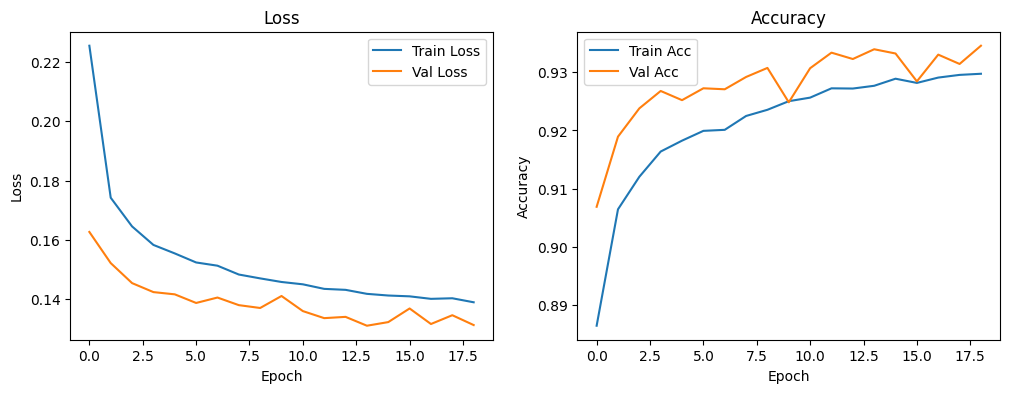

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     18600
           1       0.96      0.94      0.95     32935

    accuracy                           0.93     51535
   macro avg       0.93      0.93      0.93     51535
weighted avg       0.94      0.93      0.94     51535

ROC AUC: 0.9875617810251864


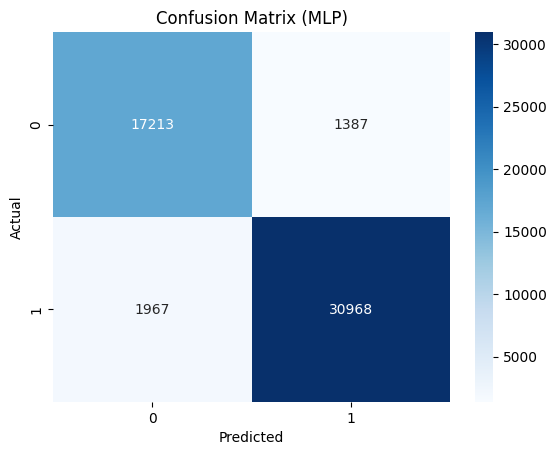

In [12]:
mlp.load_weights('best_mlp_model.h5')
y_pred_prob = mlp.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (MLP)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
import keras_tuner as kt
from tensorflow import keras

In [15]:
def build_hypermodel(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    # Tune the number of layers and units in each layer
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model

In [16]:
tuner = kt.RandomSearch(
    build_hypermodel,
    objective='val_auc',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='unsw_mlp_tuning'
)

In [17]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=[stop_early],
    batch_size=256,
    verbose=2
)

Trial 10 Complete [00h 00m 34s]
val_auc: 0.9870108962059021

Best val_auc So Far: 0.9876567125320435
Total elapsed time: 00h 05m 15s


In [18]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[stop_early],
    verbose=2
)

# Evaluate on test set
y_pred_prob = best_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_prob))

Epoch 1/30
645/645 - 4s - 7ms/step - accuracy: 0.9047 - auc: 0.9752 - loss: 0.1808 - val_accuracy: 0.9197 - val_auc: 0.9820 - val_loss: 0.1543
Epoch 2/30
645/645 - 3s - 4ms/step - accuracy: 0.9167 - auc: 0.9809 - loss: 0.1579 - val_accuracy: 0.9127 - val_auc: 0.9820 - val_loss: 0.1756
Epoch 3/30
645/645 - 3s - 4ms/step - accuracy: 0.9202 - auc: 0.9824 - loss: 0.1516 - val_accuracy: 0.9318 - val_auc: 0.9858 - val_loss: 0.1422
Epoch 4/30
645/645 - 2s - 4ms/step - accuracy: 0.9216 - auc: 0.9830 - loss: 0.1492 - val_accuracy: 0.9197 - val_auc: 0.9848 - val_loss: 0.1480
Epoch 5/30
645/645 - 3s - 4ms/step - accuracy: 0.9246 - auc: 0.9840 - loss: 0.1457 - val_accuracy: 0.9323 - val_auc: 0.9861 - val_loss: 0.1415
Epoch 6/30
645/645 - 3s - 4ms/step - accuracy: 0.9262 - auc: 0.9844 - loss: 0.1436 - val_accuracy: 0.9307 - val_auc: 0.9864 - val_loss: 0.1349
Epoch 7/30
645/645 - 3s - 4ms/step - accuracy: 0.9268 - auc: 0.9846 - loss: 0.1429 - val_accuracy: 0.9277 - val_auc: 0.9861 - val_loss: 0.1407

In [20]:
# Select only normal samples for training the autoencoder
normal_mask = (df['label'] == 0) if df['label'].dtype != 'object' else (df['label'].str.lower() == 'normal')
X_normal = X[normal_mask]
print('Normal samples for autoencoder training:', X_normal.shape)

Normal samples for autoencoder training: (93000, 196)


In [21]:
from tensorflow.keras import layers, models

def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dense(64, activation='relu')(encoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)
    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = build_autoencoder(X.shape[1])
autoencoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        12,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 196)            │        12,740 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,540 (115.39 KB)

 Trainable params: 29,540 (115.39 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_ae = autoencoder.fit(
    X_normal, X_normal,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    verbose=2
)

Epoch 1/30
291/291 - 2s - 5ms/step - loss: 0.0621 - val_loss: 0.0352
Epoch 2/30
291/291 - 1s - 3ms/step - loss: 0.0086 - val_loss: 0.0128
Epoch 3/30
291/291 - 1s - 3ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 4/30
291/291 - 1s - 2ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 5/30
291/291 - 1s - 2ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 6/30
291/291 - 1s - 2ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 7/30
291/291 - 1s - 4ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/30
291/291 - 1s - 2ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/30
291/291 - 1s - 2ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/30
291/291 - 1s - 2ms/step - loss: 9.9931e-04 - val_loss: 0.0019
Epoch 11/30
291/291 - 1s - 2ms/step - loss: 8.7568e-04 - val_loss: 0.0017
Epoch 12/30
291/291 - 1s - 2ms/step - loss: 7.9320e-04 - val_loss: 0.0016
Epoch 13/30
291/291 - 1s - 2ms/step - loss: 7.2483e-04 - val_loss: 0.0016
Epoch 14/30
291/291 - 1s - 2ms/step - loss: 6.4612e-04 - val_loss: 0.0015
Epoch 15/

In [23]:
# Reconstruction error for all samples
X_pred = autoencoder.predict(X)
mse = np.mean(np.square(X - X_pred), axis=1)

8053/8053 ━━━━━━━━━━━━━━━━━━━━ 5s 582us/step


In [24]:
# Set threshold as, e.g., 95th percentile of normal training errors
threshold = np.percentile(mse[normal_mask], 95)
print('Reconstruction error threshold:', threshold)

# Predict anomalies
anomaly_pred = (mse > threshold).astype(int)

Reconstruction error threshold: 0.0012829839409698686


              precision    recall  f1-score   support

           0       0.64      0.95      0.77     93000
           1       0.96      0.70      0.81    164673

    accuracy                           0.79    257673
   macro avg       0.80      0.83      0.79    257673
weighted avg       0.85      0.79      0.80    257673

Confusion Matrix:


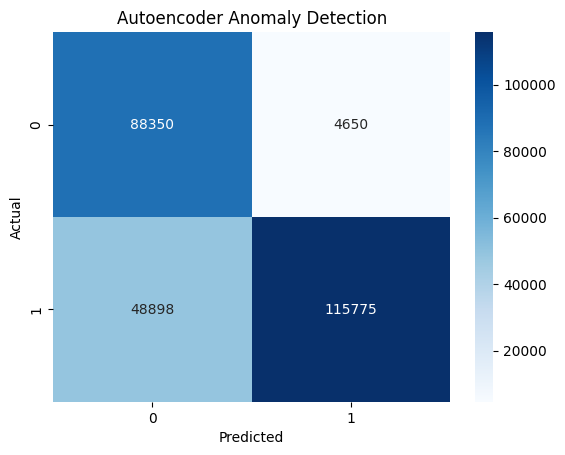

In [25]:
print(classification_report(y, anomaly_pred))
print('Confusion Matrix:')
sns.heatmap(confusion_matrix(y, anomaly_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Autoencoder Anomaly Detection')
plt.show()